# Классификация спроса для Гостиницы 'Сибирь'

__Цель:__  
Построить модель кластеризации дат в течении года для последующего применения той или иной ценовой политики

__Какие показатеи мы можем собрать для гостиницы Сибирь:__  
* __Кол-во номеров в отеле__ - фиксированное число
* __Загрузка__ - число занятых номеров в определенную дату / общее кол-во номеров
* __Доход__ - сумма полученных средств за день
* __ADR__ - средняя стоимость номера в определенный день
* __RevPAR__ - Сумма полученных денег за день / кол-во номеров в гостинице 
* __MPI__ - индекс загрузки (отношение процента загрузки в нашем отеле к проценту загрузки отелей-конкурентов)
* __ARI__ - индекс средней цены (ADR отеля / ADR отелей-конкурентов)
* __RGI__ - индекс средней цены (RevPar отеля / RevPar отелей-конкурентов)

Данные предоставлены за период Май 2023 - Май 2024 так как ранее показатели MPI, ARI и RGI не подсчитывались

__План работы:__  
Шаг 1. Загрузка данных  
Шаг 2. Предобработка данных  
Шаг 3. Исследовательский анализ  
Шаг 4. Обучение моделей машинного обучения    
Шаг 5. Общий вывод

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
import datetime
from sklearn.preprocessing import StandardScaler

In [21]:
def make_discription(data):
    print(data.info())
    print(data.describe())
    print(data.head())
    
def convert_to_float(value):
    value = value.replace('%', '').replace(',', '.')
    return float(value)

def convert_to_int(value):
    value = value.replace(' ', '')
    return int(value)

def visualize_dataframe(dataframe):
    for column in dataframe.columns:
        column_type = dataframe[column].dtype

        if column_type == 'object':
            value_counts = dataframe[column].value_counts()
            value_counts.plot.pie(autopct='%1.1f%%', startangle=90)
            plt.title(f'{column} - Круговая диаграмма')
            plt.show()

        elif column_type in ['int32', 'int64', 'float64'] and column != 'id':
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

            dataframe[column].plot.hist(bins=25, ax=axes[0])
            axes[0].set_title(f'{column} - Гистограмма')
            axes[0].set_xlabel(column)
            axes[0].set_ylabel('Частота')

            sns.boxplot(x=dataframe[column], ax=axes[1])
            axes[1].set_title(f'{column} - Boxplot')
            axes[1].set_xlabel(column)

            plt.show()
            
            print(dataframe[column].describe())        

# Шаг 1. Загрузка данных

In [22]:
data = pd.read_csv('data.csv', index_col='Дата', delimiter=';')

In [23]:
make_discription(data)

<class 'pandas.core.frame.DataFrame'>
Index: 366 entries, 01.05.2023 to 30.04.2024
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Всего
номеров  366 non-null    int64 
 1   Продано        366 non-null    int64 
 2   На
ремонте     366 non-null    int64 
 3   Загрузка       366 non-null    object
 4   Доход          366 non-null    object
 5   ADR            366 non-null    object
 6   RevPAR         366 non-null    object
 7   MPI            366 non-null    object
 8   ARI            366 non-null    object
 9   RGI            366 non-null    object
dtypes: int64(3), object(7)
memory usage: 31.5+ KB
None
       Всего\nномеров     Продано  На\nремонте
count      366.000000  366.000000   366.000000
mean        45.139344   26.852459     2.101093
std        155.714824    7.615059     2.683925
min         37.000000    5.000000     0.000000
25%         37.000000   22.000000     0.000000
50%         37.000000   29.000

# Шаг 2. Предобработка данных

Данные были проверены ранее на наличие пропусков и дубликтов, их в данных нет.

__Изменение типов данных__

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366 entries, 01.05.2023 to 30.04.2024
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Всего
номеров  366 non-null    int64 
 1   Продано        366 non-null    int64 
 2   На
ремонте     366 non-null    int64 
 3   Загрузка       366 non-null    object
 4   Доход          366 non-null    object
 5   ADR            366 non-null    object
 6   RevPAR         366 non-null    object
 7   MPI            366 non-null    object
 8   ARI            366 non-null    object
 9   RGI            366 non-null    object
dtypes: int64(3), object(7)
memory usage: 31.5+ KB


In [25]:
data['Загрузка'] = data['Загрузка'].apply(convert_to_float)
data['Доход'] = data['Доход'].apply(convert_to_int)
data['ADR'] = data['ADR'].apply(convert_to_int)
data['RevPAR'] = data['RevPAR'].apply(convert_to_int)
data['MPI'] = data['MPI'].apply(convert_to_float)
data['ARI'] = data['ARI'].apply(convert_to_float)
data['RGI'] = data['RGI'].apply(convert_to_float)
data.head()

,Всего\nномеров,Продано,На\nремонте,Загрузка,Доход,ADR,RevPAR,MPI,ARI,RGI
Дата,,,,,,,,,,
01.05.2023,37,24,1,64.9,83684,3487,2262,459.3,82.1,377.2
02.05.2023,37,27,2,73.0,109236,4046,2952,324.0,95.1,308.2
03.05.2023,37,33,2,89.2,131702,3991,3560,311.6,110.5,344.2
04.05.2023,37,33,2,89.2,121078,3669,3272,251.3,111.2,279.5
05.05.2023,37,30,1,81.1,110674,3689,2991,312.4,92.2,288.0


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366 entries, 01.05.2023 to 30.04.2024
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Всего
номеров  366 non-null    int64  
 1   Продано        366 non-null    int64  
 2   На
ремонте     366 non-null    int64  
 3   Загрузка       366 non-null    float64
 4   Доход          366 non-null    int64  
 5   ADR            366 non-null    int64  
 6   RevPAR         366 non-null    int64  
 7   MPI            366 non-null    float64
 8   ARI            366 non-null    float64
 9   RGI            366 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 31.5+ KB


Теперь типы данных установлены корректно

# Шаг 3. Исследовательский анализ

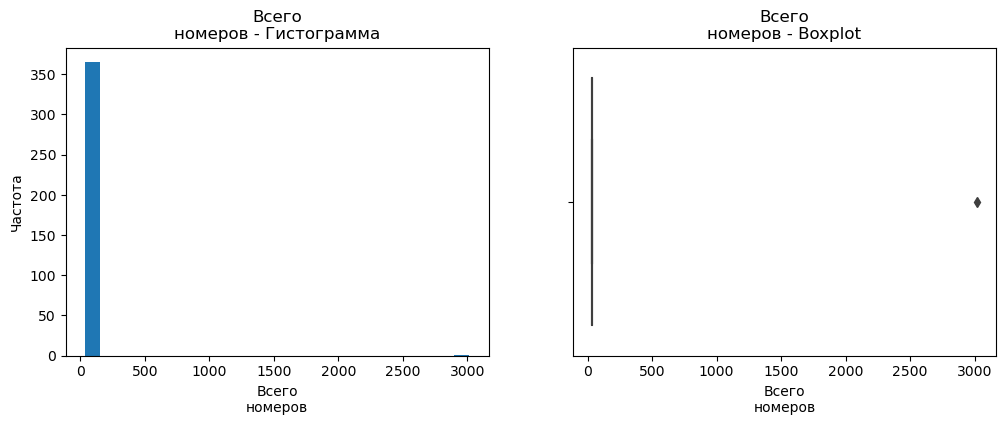

count     366.000000
mean       45.139344
std       155.714824
min        37.000000
25%        37.000000
50%        37.000000
75%        37.000000
max      3016.000000
Name: Всего\nномеров, dtype: float64


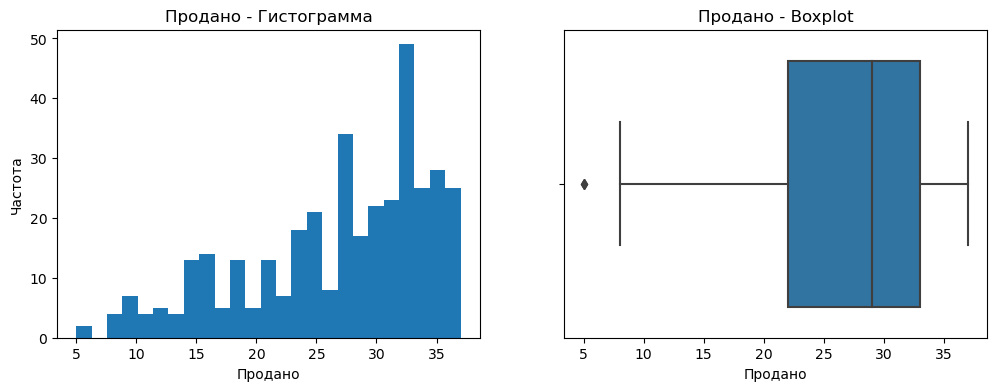

count    366.000000
mean      26.852459
std        7.615059
min        5.000000
25%       22.000000
50%       29.000000
75%       33.000000
max       37.000000
Name: Продано, dtype: float64


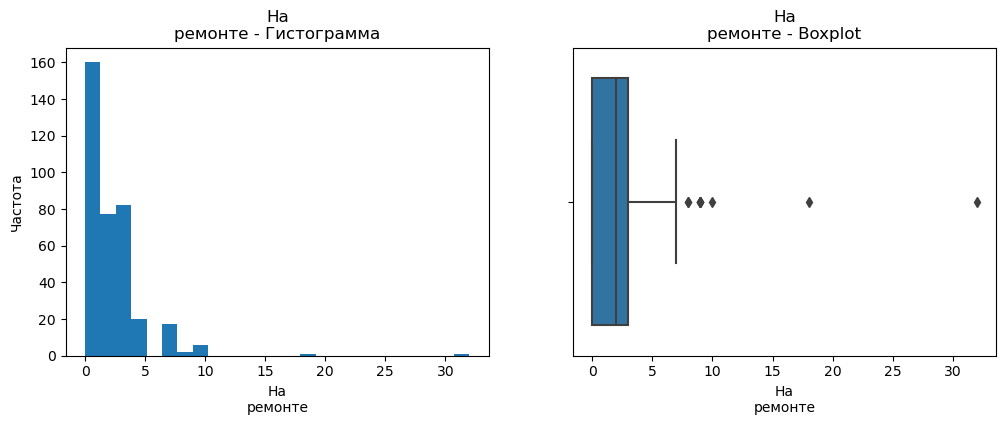

count    366.000000
mean       2.101093
std        2.683925
min        0.000000
25%        0.000000
50%        2.000000
75%        3.000000
max       32.000000
Name: На\nремонте, dtype: float64


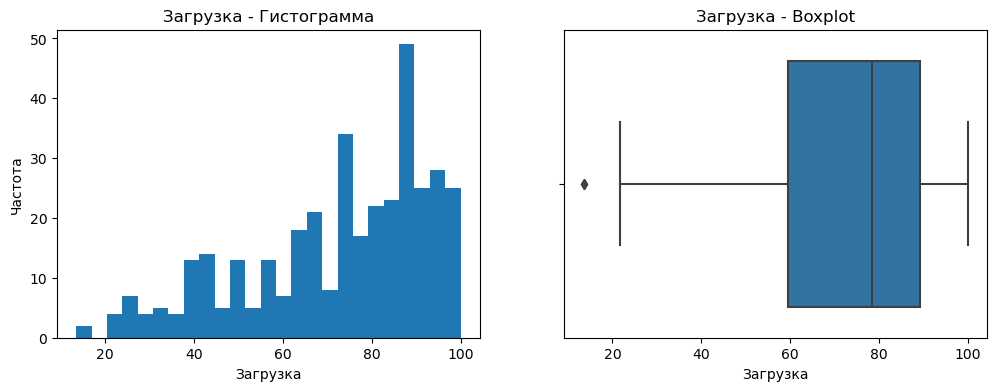

count    366.000000
mean      72.583607
std       20.591731
min       13.500000
25%       59.500000
50%       78.400000
75%       89.200000
max      100.000000
Name: Загрузка, dtype: float64


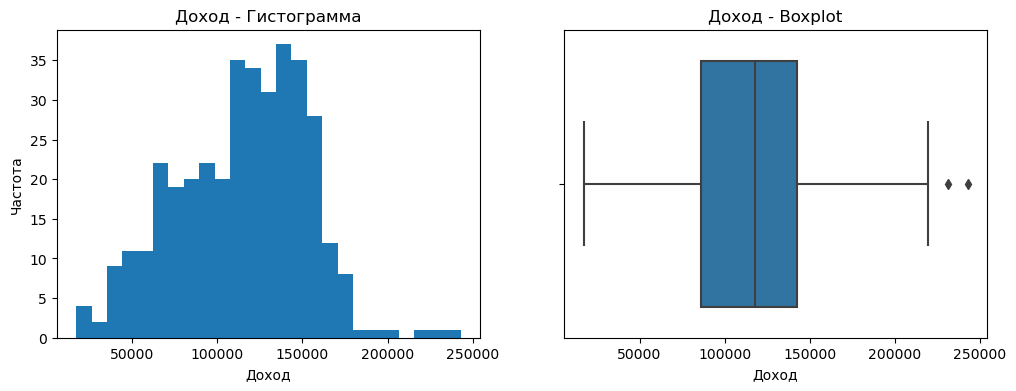

count       366.000000
mean     114478.549180
std       38123.572068
min       17075.000000
25%       85951.750000
50%      117774.500000
75%      142583.000000
max      242888.000000
Name: Доход, dtype: float64


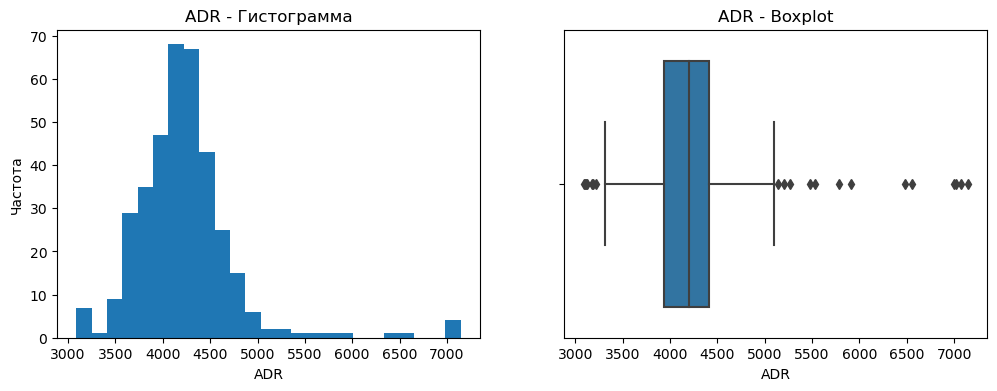

count     366.000000
mean     4226.551913
std       526.100716
min      3086.000000
25%      3939.250000
50%      4199.000000
75%      4409.250000
max      7144.000000
Name: ADR, dtype: float64


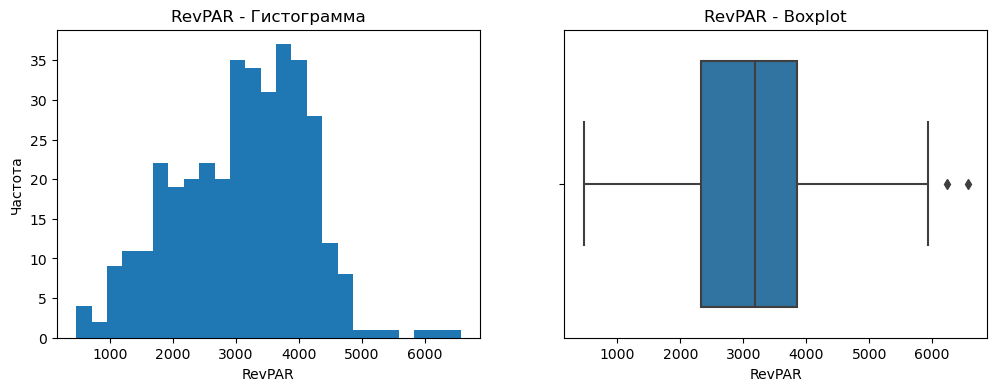

count     366.000000
mean     3093.997268
std      1030.381269
min       461.000000
25%      2323.250000
50%      3183.000000
75%      3853.750000
max      6565.000000
Name: RevPAR, dtype: float64


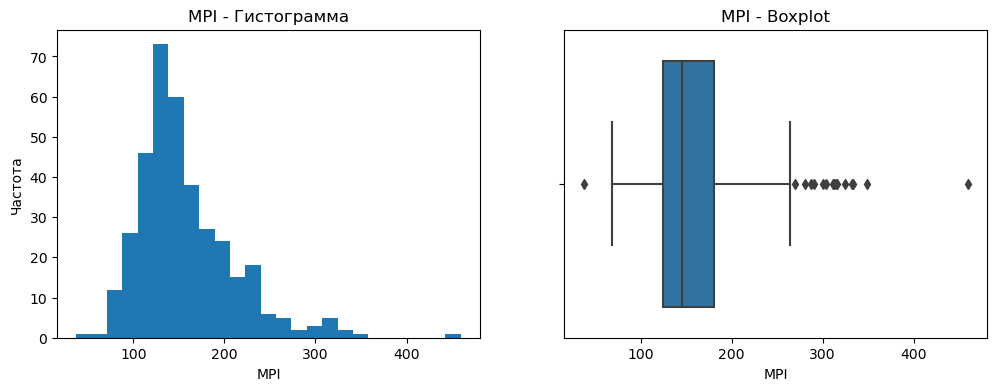

count    366.000000
mean     157.733607
std       53.577318
min       37.300000
25%      124.300000
50%      145.200000
75%      180.975000
max      459.300000
Name: MPI, dtype: float64


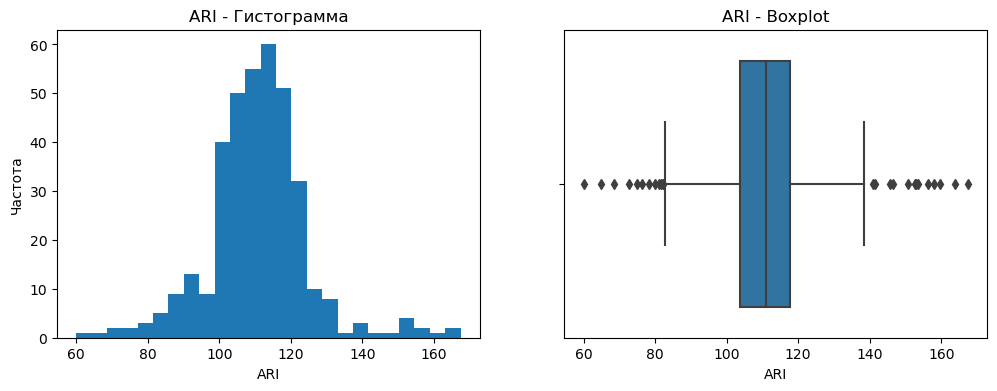

count    366.000000
mean     110.777322
std       14.069178
min       60.000000
25%      103.725000
50%      110.950000
75%      117.750000
max      167.400000
Name: ARI, dtype: float64


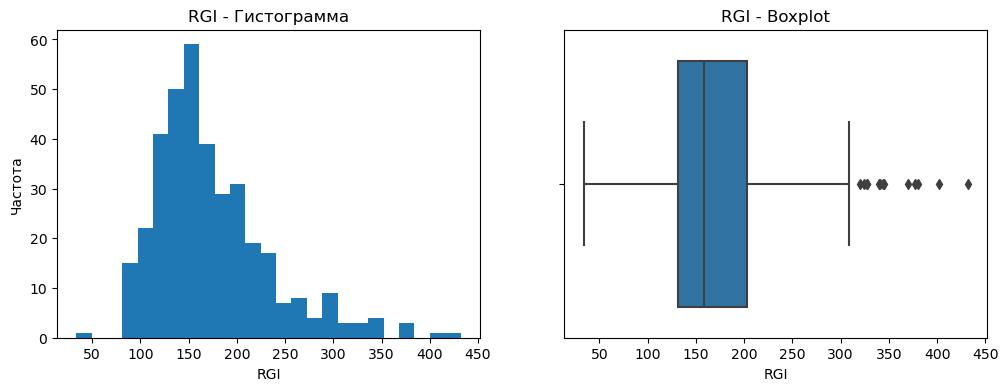

count    366.000000
mean     173.763115
std       60.097884
min       33.500000
25%      131.400000
50%      158.850000
75%      203.000000
max      431.800000
Name: RGI, dtype: float64


In [27]:
visualize_dataframe(data)

Обратим внимание на столбец 'Всего номеров', видим выброс - почему-то в определенный день число номеров увеличилось до 3016

In [28]:
filtered_data = data[data['Всего\nномеров'] == 3016]
filtered_data

,Всего\nномеров,Продано,На\nремонте,Загрузка,Доход,ADR,RevPAR,MPI,ARI,RGI
Дата,,,,,,,,,,
01.03.2024,3016,30,0,81.1,142491,4750,3851,98.7,128.6,126.9


RevPAR подсчитан верно (на 37 номеров), изменим количество номеров в этой строке на 37

In [29]:
data.loc[data['Всего\nномеров'] == 3016, 'Всего\nномеров'] = 37

В остальных данных явынх выбросов или аномалий не наблюдается

Построим матрицу корреляций для численных признаков (у нас в данных только численные признаки)

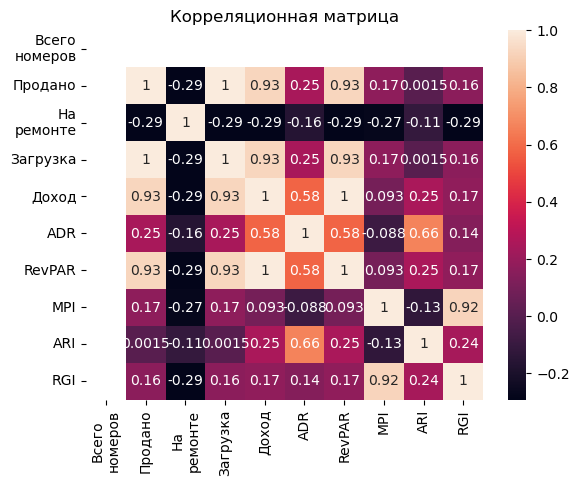

In [30]:
sns.heatmap(data.corr(), annot=True)
plt.title('Корреляционная матрица')
plt.show()

Видим, что параметр RevPAR сильно коррелирует с колличеством проданных номеров и загрузкой и доходом, что логично, ведь RevPAR - Сумма полученных денег за день / кол-во номеров в гостинице. Также довольно сильно коррелируют параметры 'Загрузка' и 'Доход', а также 'RGI' и 'MPI'
Параметр 'Загрузка' считается как кол-во проданных номеров / всего номеров(const), поэтому 'Загрузка' и 'Продано' имеют корреляцию 1

Уадлим из данных параметр 'На ремонте', ведь он никак не может показывать спрос на гостиницу в тот или иной период, параметр 'Всего номеров' как константу за весь период и 'RevPAR' и 'Продано' как параметры с мультиколлинеарностью

In [31]:
data = data.drop(columns=['Всего\nномеров', 'На\nремонте', 'RevPAR', 'Продано'])
data.head()

,Загрузка,Доход,ADR,MPI,ARI,RGI
Дата,,,,,,
01.05.2023,64.9,83684,3487,459.3,82.1,377.2
02.05.2023,73.0,109236,4046,324.0,95.1,308.2
03.05.2023,89.2,131702,3991,311.6,110.5,344.2
04.05.2023,89.2,121078,3669,251.3,111.2,279.5
05.05.2023,81.1,110674,3689,312.4,92.2,288.0


# Шаг 4. Обучение моделей 

Обучим модель кластреизации k-средних с начальными центроидами centers, посторим диагармму pairplot с заливкой по кластреам и центроидами полученных кластров. Начальные центроиды добавим отельным слоем без заливки. 

C:\Users\petre\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\petre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\petre\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\petre\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


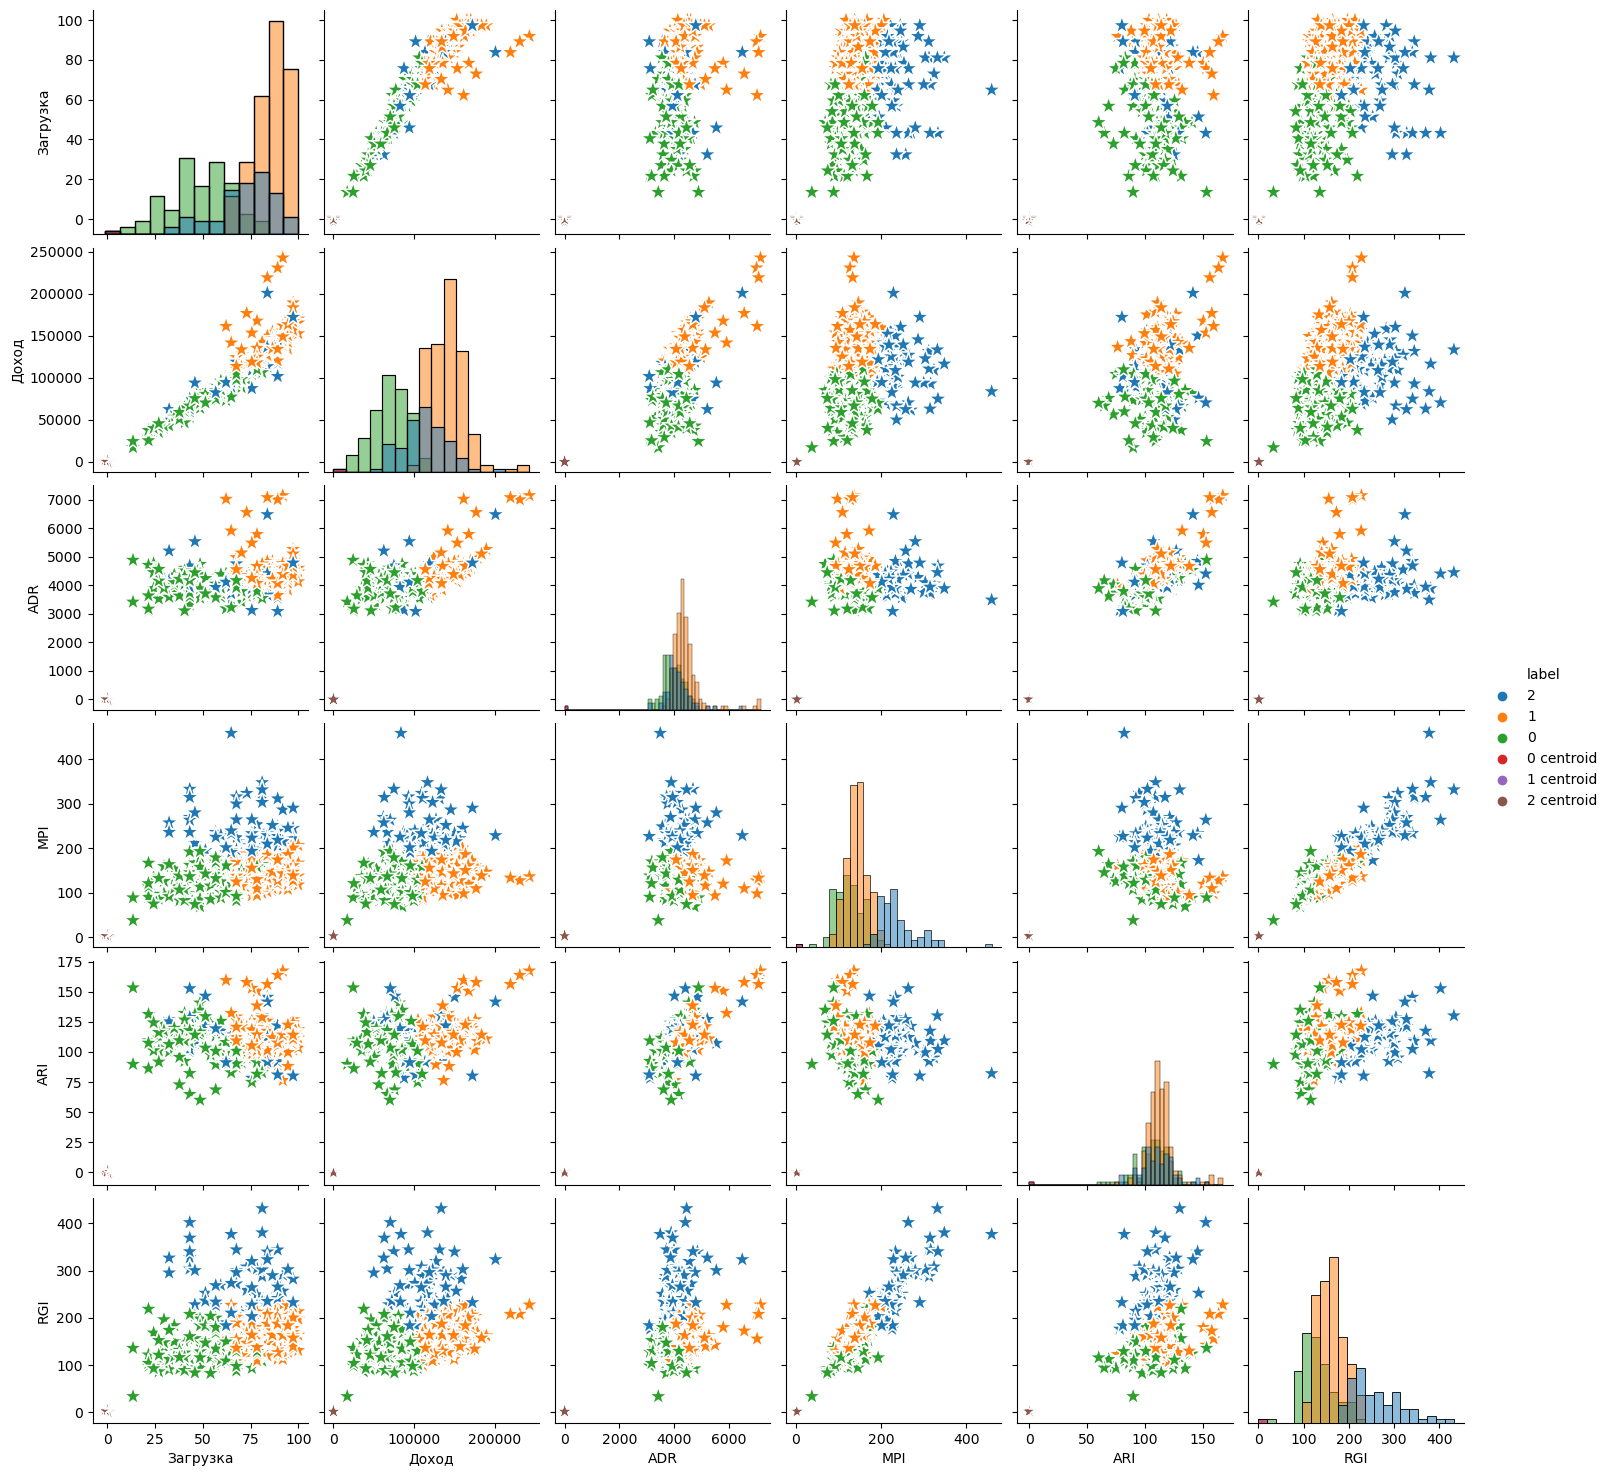

In [32]:
warnings.filterwarnings("ignore", category=RuntimeWarning) 

scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Центроиды для KMeans (также нужно шкалировать)
centers = np.array([
    [50, 80000, 3000, 200, 80, 200], 
    [80, 100000, 3500, 290, 100, 280], 
    [90, 130000, 4000, 350, 110, 300]
])
centers_scaled = scaler.transform(centers)

# Обучение модели KMeans
model = KMeans(n_clusters=3, init=centers_scaled, random_state=12345)
model.fit(data_scaled)
centroids = pd.DataFrame(model.cluster_centers_, columns=data.columns)

# Добавление меток кластеров к данным
data['label'] = model.labels_.astype(str)
centroids['label'] = ['0 centroid', '1 centroid', '2 centroid']

# Объединение данных и центроидов
data_all = pd.concat([data, centroids], ignore_index=True)

# Визуализация данных
pairgrid = sns.pairplot(data_all, hue='label', diag_kind='hist')
pairgrid.map_offdiag(sns.scatterplot, s=200, marker='*', palette='flag')

# Дополнительный слой для центроидов
centroids_init = np.array([
    [20, 80000, 3000, 200, 80, 200], 
    [50, 100000, 3500, 350, 100, 300], 
    [20, 130000, 4000, 290, 110, 280]
])
centroids_init_scaled = scaler.transform(centroids_init)
centroids_init_df = pd.DataFrame(centroids_init_scaled, columns=data.drop(columns=['label']).columns)
centroids_init_df['label'] = 4

# Объединение данных с дополнительными центроидами
data_all_with_init = pd.concat([data_all, centroids_init_df], ignore_index=True)

# Обновление данных в PairGrid
pairgrid.data = data_all_with_init

# Дополнительная визуализация для новых центроидов
pairgrid.map_offdiag(sns.scatterplot, s=200, marker='*', palette='flag')

# Показать график
plt.show()

Данные не всегда разделены чётко.Построим график метода локтя для визуализации изменеия целевой функции в зависимости от числа кластеров

C:\Users\petre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\petre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\petre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\petre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

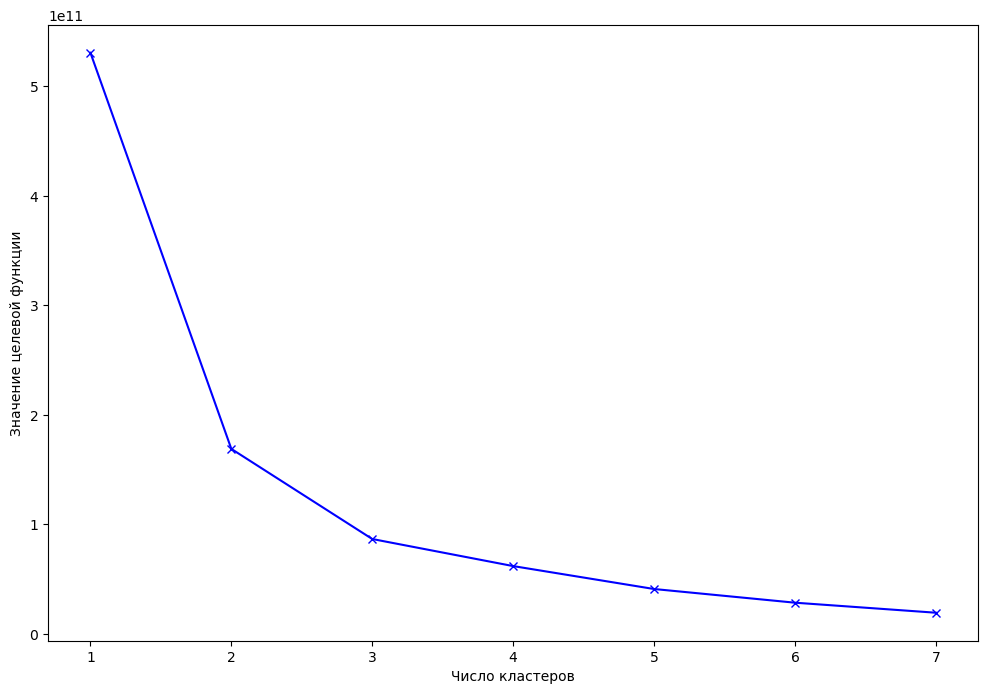

In [33]:
distortion = []
K = range(1, 8)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(data)
    distortion.append(model.inertia_) 
    
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()     

По графику видно, что выбранное количество кластеров(3) оптимально для количества ценовых стратегий, ведь дальнейшее изменение целевой функции относительно небольшое. 

# Шаг 5. Общий вывод

In [34]:
cluster_labels = data[['label']]
cluster_labels.head()

,label
Дата,
01.05.2023,2
02.05.2023,2
03.05.2023,2
04.05.2023,2
05.05.2023,2


In [35]:
cluster_labels.value_counts()

label
1        182
0        106
2         78
Name: count, dtype: int64

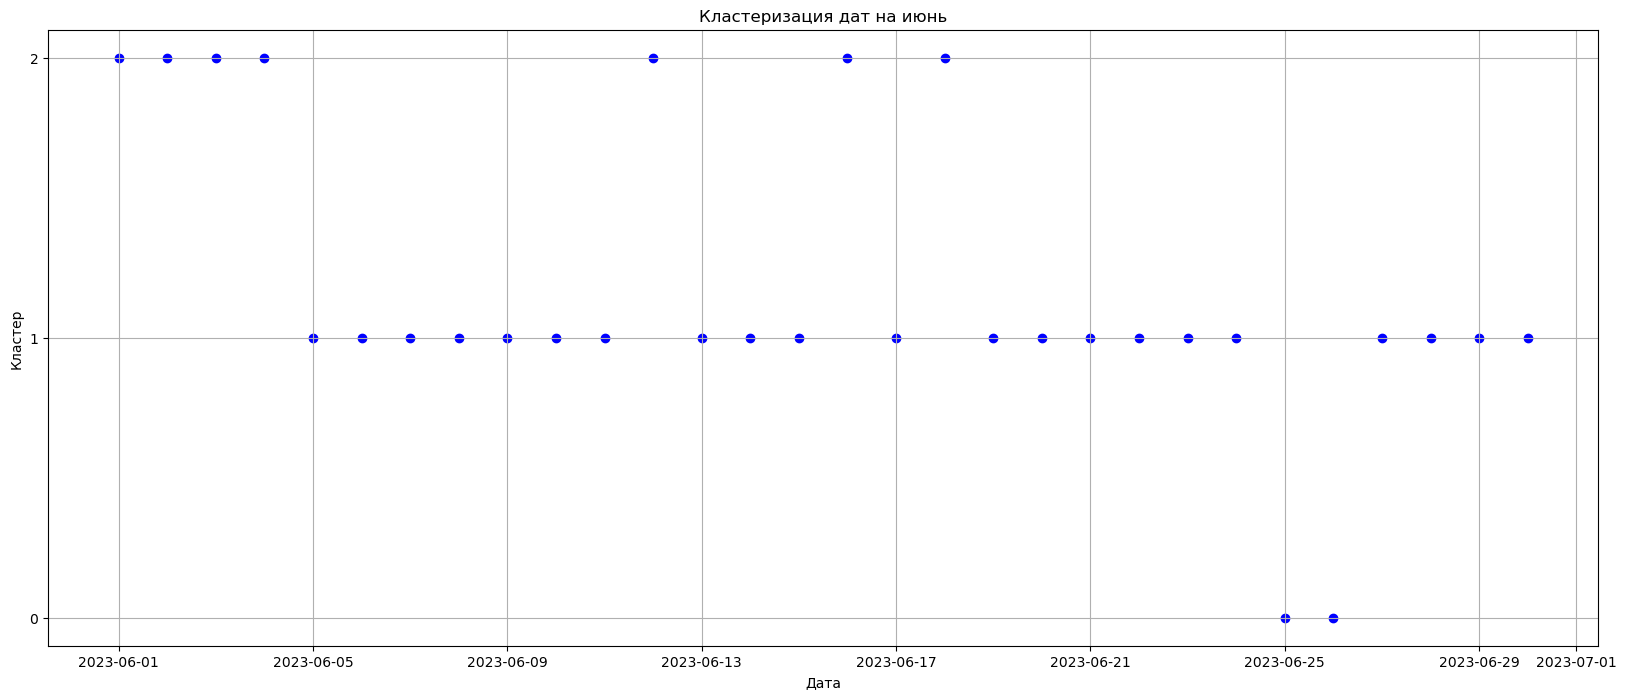

In [36]:
cluster_labels.index = pd.to_datetime(cluster_labels.index, format='%d.%m.%Y')
june_data = cluster_labels[cluster_labels.index.month == 6]
june_data_sorted = june_data.sort_index().sort_values(by='label')
plt.figure(figsize=(20, 8))
plt.scatter(june_data_sorted.index, june_data_sorted['label'], marker='o', color='blue')
plt.xlabel('Дата')
plt.ylabel('Кластер')
plt.title('Кластеризация дат на июнь')
plt.grid(True)
plt.show()


__В этом проекте я построил  модель кластеризации дат в течении года для последующего применения той или иной ценовой политики. Модель KMeans разделиила все данные на группы по 106, 182 и 78 дат, что соответствует низкому для гостиницы Сибирь сезону, среднему и высокому.__